In [1]:
import os, sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import MaaSSim

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#!pip install MaaSSim
import MaaSSim.utils
import logging
from dotmap import DotMap
import MaaSSim.simulators
from MaaSSim.data_structures import structures as inData
from MaaSSim.day_to_day import driver_opt_out, S_driver_opt_out, traveller_opt_out, S_traveller_opt_out
from MaaSSim.day_to_day import traveller_opt_out
from MaaSSim.day_to_day import d2d_kpi_veh
from MaaSSim.day_to_day import d2d_kpi_pax

In [4]:
import osmnx as ox
import networkx as nx
import random
import math
import pandas as pd
import matplotlib.pyplot as plt          
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

In [62]:
params = MaaSSim.utils.get_config('glance.json')
params.city = "Amsterdam, Netherlands"
params.paths.G = "../../data/graphs/Amsterdam.graphml"
params.paths.skim = "../../data/graphs/Amsterdam.csv"
params.vehicle_fixed_positions = True
params.times.patience = 600 #second
params.dist_threshold = 20000 #meter
params.dist_threshold_min = 2000 #meter

params.d2d.probabilistic = True
params.d2d.heterogeneous = False
params.d2d.ini_att = 0.5
params.d2d.B_income = 1
params.d2d.fuel_cost = 0.25 #euro/km

params.d2d.B_inveh_time = 1
params.d2d.B_exp_time = 2 #1.5 in oded's paper
params.PT_fare = 1 ## euro
params.PT_avg_speed = 6

params.nPM = 1 # number of platforms. platform id starts from 1
params.platforms.base_fare = 1.4 #euro
params.platforms.fare = float(1.21) #euro/km
params.platforms.min_fare = float(2) # euro
params.platforms.comm_rate = float(0.1)
params.platforms.discount = float(0.0)

params.d2d.learning_d = 1 
params.d2d.B_Experience = 0.5
params.d2d.B_WOM = 0.25
params.d2d.B_Marketing = 0.25
params.d2d.diffusion_speed = 10/100 # speed for M is twice greater than WOM.
params.d2d.m = 10
params.d2d.Eini_att = 0.01
params.d2d.adj_s = 1
params.VoT = 10.63 # value of time per hour
params.assert_me = False
params.paths.requests = 'Amsterdam_requests.csv'

params.nP = 2000
params.nV = 200
params.nD = 260
params.simTime = 4
params.d2d.res_wage = params.simTime*10.63 #euro

In [64]:
# sim = MaaSSim.simulators.simulate(params=params, logger_level=logging.WARNING)
sim = MaaSSim.simulators.simulate(params=params, f_driver_out=S_driver_opt_out,f_trav_out=S_traveller_opt_out,
                                  kpi_veh=d2d_kpi_veh,kpi_pax=d2d_kpi_pax, logger_level=logging.WARNING)

# sim = MaaSSim.simulators.simulate(params=params,kpi_pax=d2d_kpi_pax, logger_level=logging.WARNING)

This simulation uses albatros data
13-07-22 20:06:41-WARNING-Setting up 4h simulation at 2022-07-13 18:06:23 for 200 vehicles and 2000 passengers in Amsterdam, Netherlands
13-07-22 20:06:48-WARNING-simulation time 2.7 s
13-07-22 20:06:58-WARNING-simulation time 2.6 s
13-07-22 20:07:05-WARNING-simulation time 2.5 s
13-07-22 20:07:12-WARNING-simulation time 2.5 s
13-07-22 20:07:21-WARNING-simulation time 2.5 s
13-07-22 20:07:28-WARNING-simulation time 2.4 s
13-07-22 20:07:35-WARNING-simulation time 2.5 s
13-07-22 20:07:43-WARNING-simulation time 2.4 s
13-07-22 20:07:50-WARNING-simulation time 2.5 s
13-07-22 20:07:57-WARNING-simulation time 2.4 s
13-07-22 20:08:05-WARNING-simulation time 2.4 s
13-07-22 20:08:12-WARNING-simulation time 2.5 s
13-07-22 20:08:19-WARNING-simulation time 2.4 s
13-07-22 20:08:27-WARNING-simulation time 2.6 s
13-07-22 20:08:35-WARNING-simulation time 2.5 s
13-07-22 20:08:42-WARNING-simulation time 2.5 s
13-07-22 20:08:49-WARNING-simulation time 2.5 s
13-07-22 20:

Betas for Experience = 0.5, WOM = 0.25, Marketing = 0.25
fare per km =  1.21    commission =  0.1
Total profit is 468854.9936600001 Euro
----------------------------------------


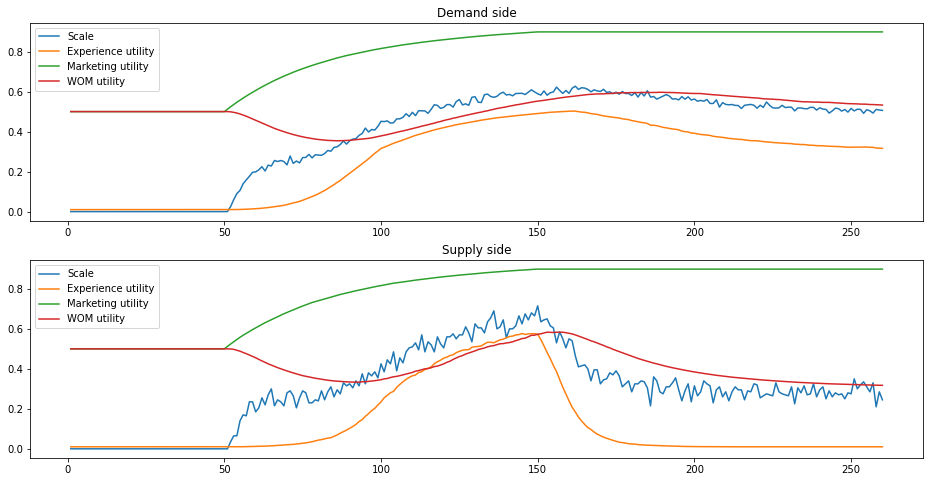

In [78]:
# with S-shaped curve nD=200 nP=2000 nV=200, with increased passenger sensitivity to changes in system
fig, ax = plt.subplots(nrows=2,figsize=(16,8))

lyp = []
lyd = []
sim = sim
for d in range(0,sim.params.nD):
    lyp.append(sim.res[d].pax_exp.OUT.value_counts().get(False, 0)/params.nP)
    lyd.append(sim.res[d].veh_exp.OUT.value_counts().get(False, 0)/params.nV)
lx = [i for i in range(1,len(lyp)+1)]

sns.lineplot(x=lx, y=lyp, label = 'Scale', ax=ax[0])#, marker='o')
sns.lineplot(x=lx, y=lyd, label = 'Scale', ax=ax[1])#, marker='o')
ax[0].set_title('Demand side')


lyp = []
lyd = []
sim = sim
for d in range(0,sim.params.nD):
    lyp.append(sim.res[d].pax_exp.EXPERIENCE_U.mean())
    lyd.append(sim.res[d].veh_exp.EXPERIENCE_U.mean())
lx = [i for i in range(1,len(lyp)+1)]
sns.lineplot(x=lx, y=lyp, label = 'Experience utility', ax=ax[0])#, marker='o')
sns.lineplot(x=lx, y=lyd, label = 'Experience utility', ax=ax[1])#, marker='o')
ax[1].set_title('Supply side')


lyp = []
lyd = []
sim = sim
for d in range(0,sim.params.nD):
    lyp.append(sim.res[d].pax_exp.MARKETING_U.mean())
    lyd.append(sim.res[d].veh_exp.MARKETING_U.mean())
lx = [i for i in range(1,len(lyp)+1)]
sns.lineplot(x=lx, y=lyp, label = 'Marketing utility', ax=ax[0])#, marker='o')
sns.lineplot(x=lx, y=lyd, label = 'Marketing utility', ax=ax[1])#, marker='o')

lyp = []
lyd = []
sim = sim
for d in range(0,sim.params.nD):
    lyp.append(sim.res[d].pax_exp.WOM_U.mean())
    lyd.append(sim.res[d].veh_exp.WOM_U.mean())
lx = [i for i in range(1,len(lyp)+1)]
sns.lineplot(x=lx, y=lyp, label = 'WOM utility', ax=ax[0])#, marker='o')
sns.lineplot(x=lx, y=lyd, label = 'WOM utility', ax=ax[1])#, marker='o')

print('Betas for Experience = {}, WOM = {}, Marketing = {}'.format(sim.params.d2d.B_Experience, sim.params.d2d.B_WOM, sim.params.d2d.B_Marketing))
print('fare per km = ',sim.params.platforms.fare,'   commission = ',sim.params.platforms.comm_rate,)
print('Total profit is {} Euro'.format(profit(sim)))
print('----------------------------------------')

In [66]:
df = sim.res[250].pax_exp
df[df.rh_U>df.alt_U]

,rh_U,alt_U,ACTUAL_WT,U_dif,OUT,mu,nDAYS_HAILED,EXPERIENCE_U,MARKETING_U,WOM_U,...,ACCEPTS_OFFER,REJECTS_OFFER,ARRIVES_AT_PICKUP,MEETS_DRIVER_AT_PICKUP,DEPARTS_FROM_PICKUP,ARRIVES_AT_DROPOFF,SETS_OFF_FOR_DEST,ARRIVES_AT_DEST,PREFERS_OTHER_SERVICE,LOSES_PATIENCE
pax,,,,,,,,,,,,,,,,,,,,,
1,-4.989821,-5.165796,0.000000,0.000000,True,0,74.0,0.010000,0.896584,0.528813,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0
3,-7.504480,-8.319010,3.266667,-0.097912,False,1,150.0,0.990000,0.905787,0.595537,...,15.0,0,20.0,196.0,30.0,328.0,10.0,0,0,0
4,-7.364530,-7.427070,0.000000,0.000000,True,0,60.0,0.010000,0.885472,0.446319,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0
5,-7.931537,-8.770388,2.283333,-0.095646,False,1,134.0,0.138756,0.885472,0.750538,...,15.0,0,20.0,137.0,30.0,380.0,10.0,0,0,0
6,-4.548451,-4.717285,0.000000,0.000000,True,0,63.0,0.010000,0.920117,0.528735,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992,-9.213602,-9.927972,0.000000,0.000000,True,0,74.0,0.010202,0.854681,0.695902,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0
1993,-7.145998,-8.245668,0.000000,0.000000,True,0,60.0,0.010000,0.871816,0.490282,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0
1997,-9.486972,-10.084653,0.000000,0.000000,True,0,90.0,0.010000,0.925795,0.443275,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0


In [37]:
1.000000e+00

1.0

In [39]:
from numpy import log as ln

In [57]:
1/(1+math.exp(params.d2d.learning_d*(ln((1/0.99999999999999)-1)+1)))

0.9999999999999729

<AxesSubplot:>

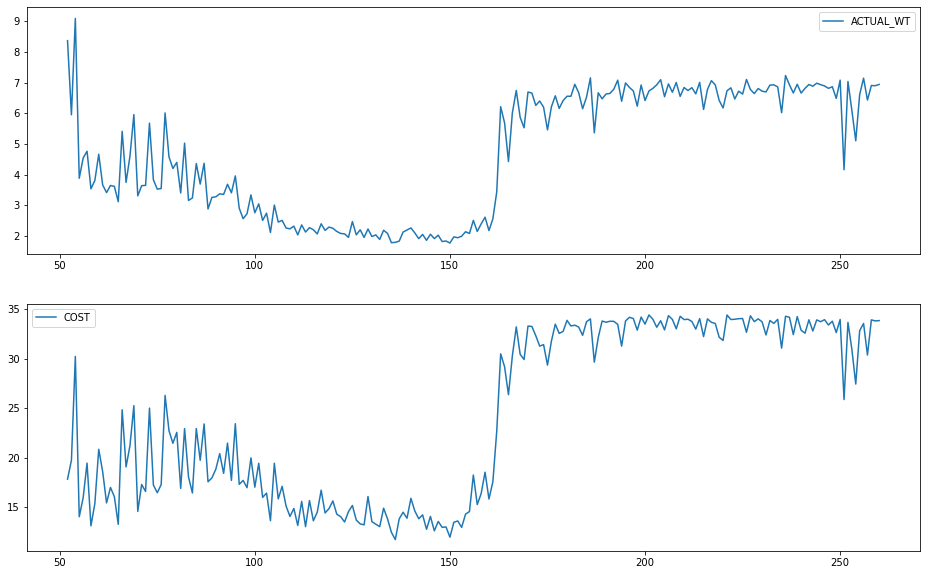

In [67]:
fig, ax = plt.subplots(nrows=3, figsize=(16,10))

x = []
yw = []
yp = []
ym = []

for d in range(0,sim.params.nD):
    df = sim.res[d].pax_exp
    yw.append(df[df.OUT==False].ACTUAL_WT.mean())
    ym.append(df[df.OUT==False].COST.mean())
    
    df = sim.res[d].veh_exp
    yp.append(df[df.OUT==False].PICKUP_DIST.mean())
    
    
x = [i for i in range(1,len(yp)+1)]
sns.lineplot(x=x, y=yw, label = 'ACTUAL_WT', ax=ax[0])#, marker='o')
sns.lineplot(x=x, y=yp, label = 'PICKUP_DIST', ax=ax[1])#, marker='o')
sns.lineplot(x=x, y=ym, label = 'MATCHING_T', ax=ax[2])#, marker='o')

<AxesSubplot:>

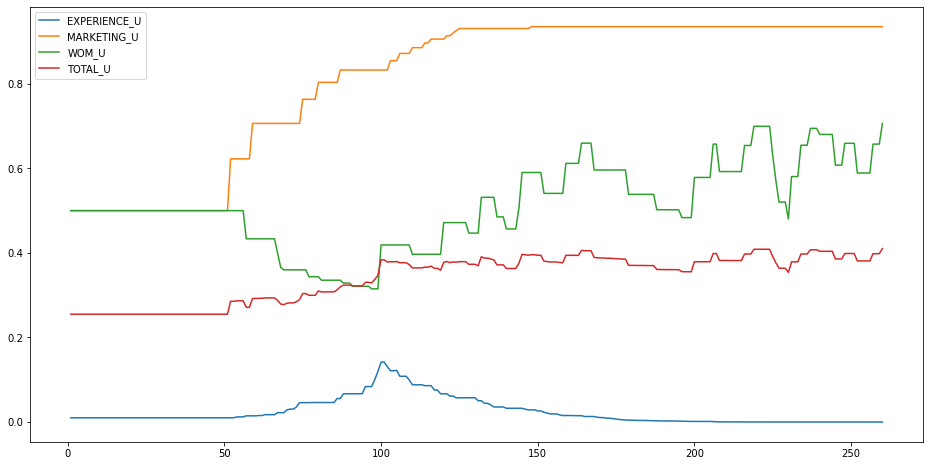

In [25]:
# individual assessment of agents
fig, ax = plt.subplots(figsize=(16,8))

pax_id = 4
x = []
ye = []
ym = []
yw = []
yu = []

for d in range(0,sim.params.nD):
    ye.append(sim.res[d].pax_exp.loc[pax_id].EXPERIENCE_U)
    ym.append(sim.res[d].pax_exp.loc[pax_id].MARKETING_U)
    yw.append(sim.res[d].pax_exp.loc[pax_id].WOM_U)
    yu.append((0.5*ye[-1])+(0.25*ym[-1])+(0.25*yw[-1]))
    
x = [i for i in range(1,len(ye)+1)]
sns.lineplot(x=x, y=ye, label = 'EXPERIENCE_U')#, ax=ax[0])#, marker='o')
sns.lineplot(x=x, y=ym, label = 'MARKETING_U')#, ax=ax[1])#, marker='o')
sns.lineplot(x=x, y=yw, label = 'WOM_U')#, ax=ax[2])#, marker='o')
sns.lineplot(x=x, y=yu, label = 'TOTAL_U')#, ax=ax[3])#, marker='o')

In [8]:
def profit(sim):

    profit = 0
    for d in range(0,len(sim.res)):
        profit = profit + sim.res[d].veh_exp.COMMISSION.sum()

    return profit

profit(sim)

0.0

In [50]:
df = sim.res[2].pax_exp
df[df.OUT==False]

,rh_U,alt_U,ACTUAL_WT,U_dif,OUT,mu,nDAYS_HAILED,EXPERIENCE_U,MARKETING_U,WOM_U,...,ACCEPTS_OFFER,REJECTS_OFFER,ARRIVES_AT_PICKUP,MEETS_DRIVER_AT_PICKUP,DEPARTS_FROM_PICKUP,ARRIVES_AT_DROPOFF,SETS_OFF_FOR_DEST,ARRIVES_AT_DEST,PREFERS_OTHER_SERVICE,LOSES_PATIENCE
pax,,,,,,,,,,,,,,,,,,,,,
10,-9.701286,-10.376369,5.133333,-0.065060,False,1.0,1.0,0.010665,0.622459,0.5,...,15.0,0.0,20.0,308.0,30.0,430.0,10.0,0.0,0.0,0.0
48,-6.059529,-5.955224,2.466667,0.017515,False,1.0,2.0,0.006859,0.706312,0.5,...,15.0,0.0,20.0,148.0,30.0,251.0,10.0,0.0,0.0,0.0
58,-6.698286,-5.382923,3.950000,0.244359,False,1.0,1.0,0.007849,0.622459,0.5,...,15.0,0.0,20.0,237.0,30.0,259.0,10.0,0.0,0.0,0.0
71,-7.217476,-5.479529,3.666667,0.317171,False,1.0,1.0,0.007302,0.622459,0.5,...,15.0,0.0,20.0,220.0,30.0,300.0,10.0,0.0,0.0,0.0
85,-10.144884,-8.848796,3.850000,0.146471,False,1.0,1.0,0.008649,0.622459,0.5,...,15.0,0.0,20.0,231.0,30.0,490.0,10.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1902,-5.306564,-5.530151,1.466667,-0.040431,False,1.0,1.0,0.010408,0.622459,0.5,...,15.0,0.0,20.0,88.0,30.0,225.0,10.0,0.0,0.0,0.0
1919,-9.745904,-9.008331,0.950000,0.081877,False,1.0,1.0,0.009221,0.500000,0.5,...,15.0,0.0,20.0,57.0,30.0,532.0,10.0,0.0,0.0,0.0
1948,-10.961306,-14.989472,0.900000,-0.268733,False,1.0,1.0,0.013043,0.622459,0.5,...,15.0,0.0,20.0,54.0,30.0,614.0,10.0,0.0,0.0,0.0


In [55]:
df = sim.runs[40].rides
df[df.veh==10].pos[0]

722976570.0

In [82]:
sim.res[155].pax_exp

,rh_U,alt_U,ACTUAL_WT,U_dif,OUT,mu,nDAYS_HAILED,EXPERIENCE_U,MARKETING_U,WOM_U,...,ACCEPTS_OFFER,REJECTS_OFFER,ARRIVES_AT_PICKUP,MEETS_DRIVER_AT_PICKUP,DEPARTS_FROM_PICKUP,ARRIVES_AT_DROPOFF,SETS_OFF_FOR_DEST,ARRIVES_AT_DEST,PREFERS_OTHER_SERVICE,LOSES_PATIENCE
pax,,,,,,,,,,,,,,,,,,,,,
0,-13.472328,-12.043958,0.000000,0.000000,True,0,30.0,0.010000,0.930734,0.679636,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0
1,-4.989821,-5.165796,0.000000,0.000000,True,0,36.0,0.010000,0.896584,0.730184,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0
2,-14.159383,-11.189253,0.000000,0.000000,True,0,35.0,0.010000,0.905787,0.612935,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0
3,-7.504480,-8.319010,3.266667,-0.097912,False,1,67.0,0.990000,0.905787,0.601857,...,15.0,0,20.0,196.0,30.0,328.0,10.0,0,0,0
4,-7.364530,-7.427070,0.000000,0.000000,True,0,29.0,0.025238,0.885472,0.533514,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-7.342593,-8.323612,3.683333,-0.117860,False,1,49.0,0.990000,0.885472,0.609996,...,15.0,0,20.0,221.0,30.0,308.0,10.0,0,0,0
1996,-11.207828,-10.922370,0.000000,0.000000,True,0,24.0,0.020220,0.896584,0.618186,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0
1997,-10.065716,-10.084653,1.633333,-0.001878,False,1,51.0,0.466972,0.925795,0.471063,...,15.0,0,20.0,98.0,30.0,537.0,10.0,0,0,0


In [83]:
df = sim.runs[155].trips
df[df.pax==3]

,pax,pos,t,event,veh_id
0,3,2309566354,0,STARTS_DAY,NaN
1,3,2309566354,14195,REQUESTS_RIDE,NaN
2,3,2309566354,14195,RECEIVES_OFFER,NaN
3,3,2309566354,14210,ACCEPTS_OFFER,NaN
4,3,2309566354,14230,ARRIVES_AT_PICKUP,191.0
5,3,2309566354,14426,MEETS_DRIVER_AT_PICKUP,191.0
6,3,2309566354,14456,DEPARTS_FROM_PICKUP,191.0
7,3,46429524,14784,ARRIVES_AT_DROPOFF,191.0
8,3,46429524,14794,SETS_OFF_FOR_DEST,NaN
9,3,46429524,14794,ARRIVES_AT_DEST,NaN


In [85]:
sim.runs[255].trips

,pax,pos,t,event,veh_id
0,0,46424527,0,STARTS_DAY,NaN
1,0,46424527,0,PREFERS_OTHER_SERVICE,NaN
0,1,46399888,0,STARTS_DAY,NaN
1,1,46399888,9848,REQUESTS_RIDE,NaN
2,1,46399888,10463,LOSES_PATIENCE,NaN
...,...,...,...,...,...
5,1999,46377386,8615,MEETS_DRIVER_AT_PICKUP,191.0
6,1999,46377386,8645,DEPARTS_FROM_PICKUP,191.0
7,1999,46380482,9007,ARRIVES_AT_DROPOFF,191.0
8,1999,46380482,9017,SETS_OFF_FOR_DEST,NaN


In [ ]:
platform control levers:
    1. trip fare
    2. commission rate
    3. discount
    4. self-supply

In [ ]:
Base scenario: trip fare = 1.21, commission rate = 0%

Results:
    1- trip fare+  
    2- trip fare+  commission rate+
    3- trip fare-  
    4- trip fare-  commission rate+
    5- selfsupply
    6- asset-heavy, autonomous and electric fleets 
    
    7- best way to enlarge the scale (with out wasting money) would be to apply discounts for travellers who assign less utility to rs than pt. 

In [ ]:
tragedy of commons
early adopters and late adopters

In [ ]:
Important remarks:
    
1- Scince the urilities are changing in (0,1), each driver should converge to a specific attitude 0 or 1.
After a while. This does not happen in Arjan's or Djavadians model.

2- The stability of on driver depends on endogenous factor of EXPERIENCE_U and WOM and Marketing. So we
will see the complete convergance will happen when the marketing reaches to max effect 1. and other drivers
converge (wom).

3- large scales on both demand and supply sides brings an extra utility in terms of lower pick up times.

4- increasing we increase the coefficient of the diff in experience, agents are learning faster.

5- in the basic model drivers are more sensitive than passengers to the changes in system. Because 
passengers are considering other factors like trip fare beside waiting time. That is why driver scale obeys
passenger scale. This prevents the network effect to happen. however, to increase passenger sensitivity we
increase the wait time coefficient in the utility formula.

6- in some scenarios with high trip fare we can observe that the coevolution does not experience the network
effect ant after a small growth in the initial phase it remains same. This is because of zero experience
utility on demand side. so passenger always asign lower utility to the rs but they use it occasionally, 
since the model is probabilistic. On driver side we will have the same drivers but what about demand?!

7- According to literature wom has twice greater effect than traditional marketing but whith slower diffusion
this can be reflected to diffusion speed and betas.

8- not now but in future it would be interesting to add memory decay in the learning formula.

9- it seems the platform scale highly depends on the travllers. waiting time has limmited effect on 
travellers number. therefor, the only way to enlarge the scale a little more is to play with trip fare 
but through applying discounts for the traveller choosing pt. 

10- dont forget to fix the positions for drivers.

11- dont forget to calculate the platform profit from the trip fares assigned to passengers. otherwise, 
in case of discount you will get a wrong profit value.

In [ ]:
1. word of mouth? 0 or 0.5 considering rh_U starting from 0!
2. Experinced utility of rh is never worse than pt!